In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

import glob
import joblib

In [ ]:
datagen = ImageDataGenerator(rescale=1./255.)

In [21]:
train = datagen.flow_from_directory('vgg/train', target_size=(224, 224), 
                                    class_mode='categorical', batch_size=32)
val = datagen.flow_from_directory('vgg/val', target_size=(224, 224),
                                  class_mode='categorical', batch_size=32)

Found 93 images belonging to 5 classes.
Found 25 images belonging to 5 classes.


In [5]:
train.class_indices

{'ben_afflek': 0,
 'elton_john': 1,
 'jerry_seinfeld': 2,
 'madonna': 3,
 'mindy_kaling': 4}

In [6]:
idx_to_class = {v: k for k, v in train.class_indices.items()}
idx_to_class

{0: 'ben_afflek',
 1: 'elton_john',
 2: 'jerry_seinfeld',
 3: 'madonna',
 4: 'mindy_kaling'}

In [7]:
model = VGG16(include_top=False, input_shape=(224, 224, 3))

58892288/58889256 [==============================] - 5s 0us/step


In [8]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
for layer in model.layers:
    layer.trainable = False

In [10]:
flatten = Flatten(name='flatten')(model.layers[-1].output)
features_1 = Dense(1024, activation='relu', name='features_1')(flatten)
dropout_1 = Dropout(0.5, name='dropout_1')(features_1)
features_2 = Dense(1024, activation='relu', name='features_2')(dropout_1)
dropout_2 = Dropout(0.5, name='dropout_2')(features_2)
classification = Dense(5, activation='softmax', name='classification')(dropout_2)

model = Model(inputs=model.inputs, outputs=classification)

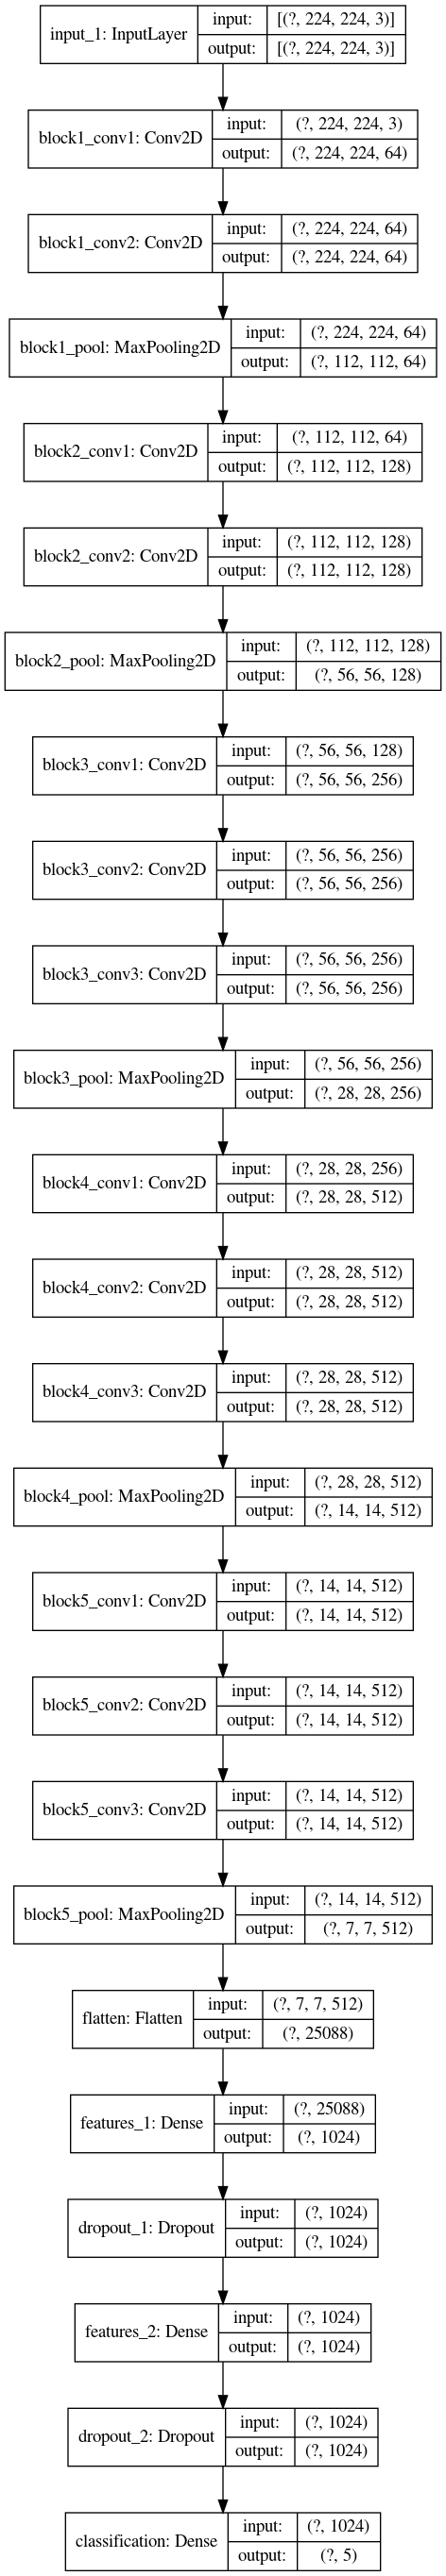

In [11]:
plot_model(model, show_shapes=True)

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [32]:
# history = model.fit(train, epochs=50,
#                     validation_data=val,
#                     callbacks=[early_stopping])
model = load_model('model.h5')

In [2]:
history = joblib.load('history.dump')

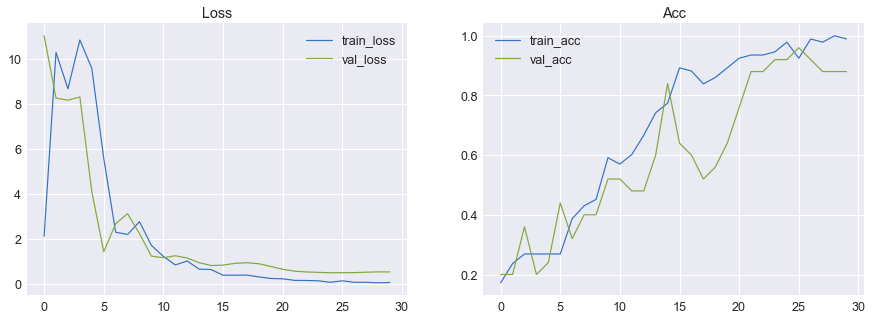

In [3]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.title('Loss')
plt.plot(history['loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(122)
plt.title('Acc')
plt.plot(history['acc'], label='train_acc')
plt.plot(history['val_acc'], label='val_acc')
plt.legend()

plt.show()

In [29]:
test_images = glob.glob('vgg/test/*')

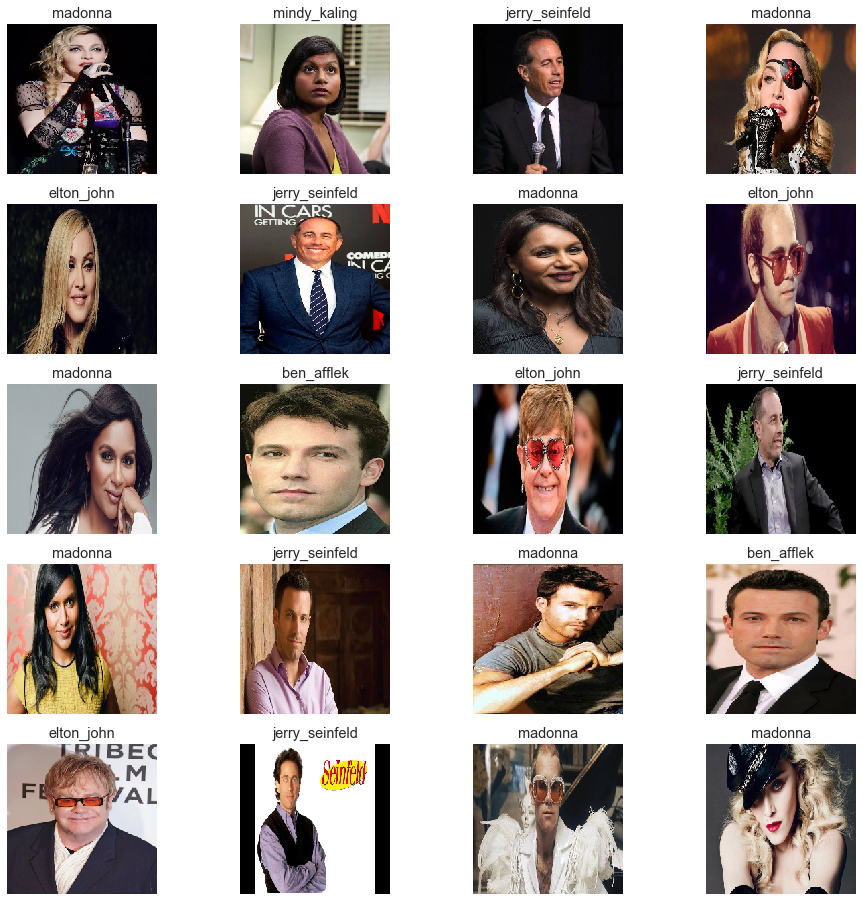

In [34]:
fig = plt.figure(figsize=(16,16))

test_images = glob.glob('vgg/test/*')
for i, image in enumerate(test_images):
    plt.subplot(5, 4, i+1)
    img = load_img(image, target_size=(224, 224))
    img = img_to_array(img) / 255.
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))

    plt.title(idx_to_class[np.argmax(model.predict(img))])
    plt.imshow(img[0])
    plt.axis('off')

plt.show()

In [31]:
# !wget -O 'img.jpg' 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSsS9uPBBEe_lWe13RoF642sTUiWKmYIaFtOD7gxO9nURILeKON'

# img = load_img('img.jpg', target_size=(224, 224))
# img = img_to_array(img) / 255.
# img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))

# plt.title(idx_to_class[np.argmax(model.predict(img))])
# plt.axis(False)
# plt.imshow(img[0])
# plt.show()